------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis)__ 
------------------------------------------------------------------------------------------------------------------------

In [1]:
#this line imports the functions needed for this project
from source_code.general_functions import select_time_range
from source_code.dwd_data_explore import get_links, show_available_data, ids_datapoints, common_stations, plot_points_germany
from source_code.dwd_data_download import download_dwd_data
from source_code.plot_functions import plot_optimal_temperature, plot_lw_RHt, plot_lw_dpd, plot_dryness
from source_code.fusarium import plot_risk_fusarium, equation_fusarium, equation_fusarium_rh
from source_code.bbch_functions import plot_harvest_date_mais, quantile_date_stage_crop

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Hypothesis

1) Recent (since 1990 ) changes in climate cause more frequent favourable disease events in key phenological stages that potentially lead to infection risk than the years before (1950-1989).

2) However, those changes occur at different intensities across Germany. Higher risks in the more martime regions (higher rainfall &  higher temperature)

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [2]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters = parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [3]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (common_stations(common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['04104', '03631', '00701', '04887', '00691', '05371', '02261', '00867', '01639', '05705', '05906', '01691', '03730', '00656', '02597', '05792', '02290', '05100', '01975', '02014', '03032', '04371', '02601', '01550']


Upon data check, I noticed that id "02290" has the moisture only for one year, even though in the name it says that it is available for all the timeframe. It will be removed from the analysis.

In [4]:
try:
    common_ids.remove("02290")
except:
    print("ID was already removed")

### Let's plot the stations to make sure that the points are representative for whole Germany:

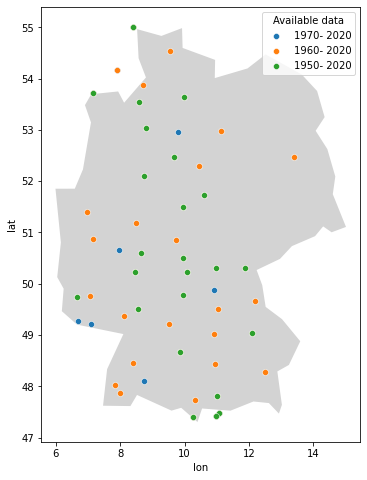

In [5]:
plot_points_germany(dwd_links)

In [6]:
#to_exp = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")
#to_exp.id = to_exp.id.apply(lambda x: str(x).zfill(5))
#to_exp.to_csv("app/coordinates.csv")

#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

### Approximating BBCH for analysis




Q1 quantile of arr :  260.0
Q2 quantile of arr :  269.0
Q3 quantile of arr :  280.0
90% of corn is harvested at :  289.0
95% of corn is harvested at :  295.0
99% of corn is harvested at :  304.0


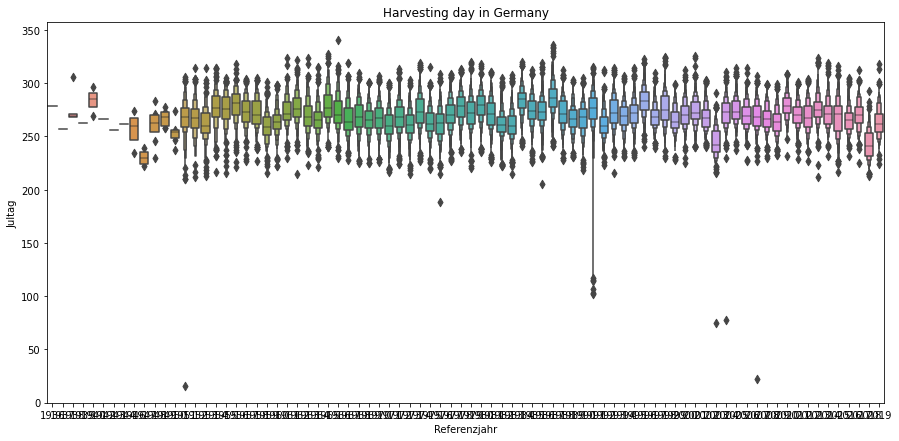

In [7]:
plot_harvest_date_mais()

In [8]:
corn_harvest_date = quantile_date_stage_crop("mais",0.90,24)
wheat_bbch75 = quantile_date_stage_crop("wheat",0.90,19)

wheat_sawing_date = quantile_date_stage_crop("wheat",0.90,10)
wheat_harvest_date = quantile_date_stage_crop("wheat",0.90,23)
print(f"""Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest {corn_harvest_date}
Wheat - bbch75 {wheat_bbch75}

General for wheat:
------------------------
 Sawing date: {wheat_sawing_date}
 Harvest: {wheat_harvest_date}
 """)

Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest 16.10
Wheat - bbch75 20.07

General for wheat:
------------------------
 Sawing date: 27.10
 Harvest: 26.08
 


## Step 2. Results
### 1. Temperature

In [9]:
df_airtemp = download_dwd_data("air_temperature","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)
#Replacing non-existent values
df_airtemp.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


(0.0, 300000.0)

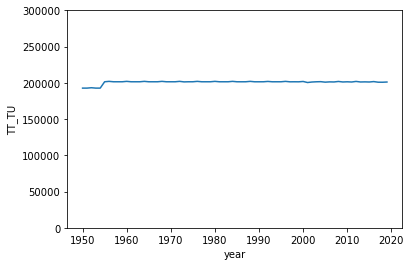

In [10]:
#Step 1. Checking data integrity:

df = df_airtemp.copy()
measures = df.groupby("year").count()
fig = plt.figure()
ax = sns.lineplot(x=measures.index,y=measures.TT_TU)
ax.set_ylim(bottom = 0, top = 300000)


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

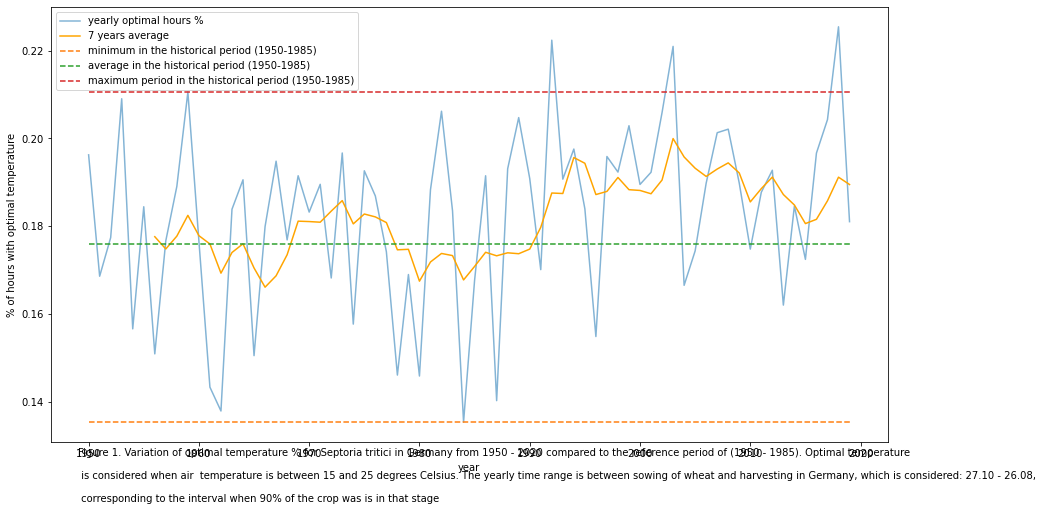

In [11]:
plot_optimal_temperature(df_airtemp, 
    temp_min=15,temp_max=25,
    hist_start=1950,hist_end=1985,
    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
    moving_average=7)

### 2. Leaf wetness

In [12]:
df_moisture= download_dwd_data("moisture","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing non-existent values
df_moisture.replace(-99.9, np.nan, inplace=True)

All given ids accounted for


Text(0, 0.5, 'Number of measures')

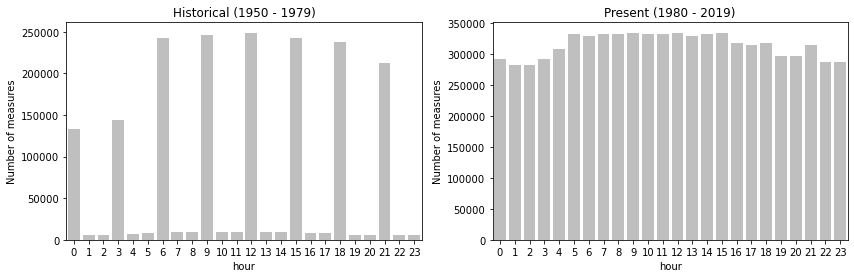

In [13]:
hist_moisture = df_moisture[df_moisture["year"]<1980].groupby("hour").count()
recent_moisture = df_moisture[df_moisture["year"]>=1980].groupby("hour").count()

fig, ax =plt.subplots(1,2,figsize=(14,4))
sns.barplot(x= hist_moisture.index, y = hist_moisture["RF_STD"], color = "0.75", ax= ax[0])
sns.barplot(x= recent_moisture.index, y = recent_moisture["RF_STD"], color = "0.75", ax= ax[1])
ax[0].set_title("Historical (1950 - 1979)")
ax[1].set_title("Present (1980 - 2019)")
ax[0].set_ylabel("Number of measures")
ax[1].set_ylabel("Number of measures")

We can observe from here that in this time period, the relative humidity was mostly measured from 3 to 3 hours, during the working time, as the measuring process was mostly manual.
From 1980, the data is measured more constantly. The variation in the RH analysis comes from here.

### Now let's try to plot it only for the hours where we have the measurement value correct

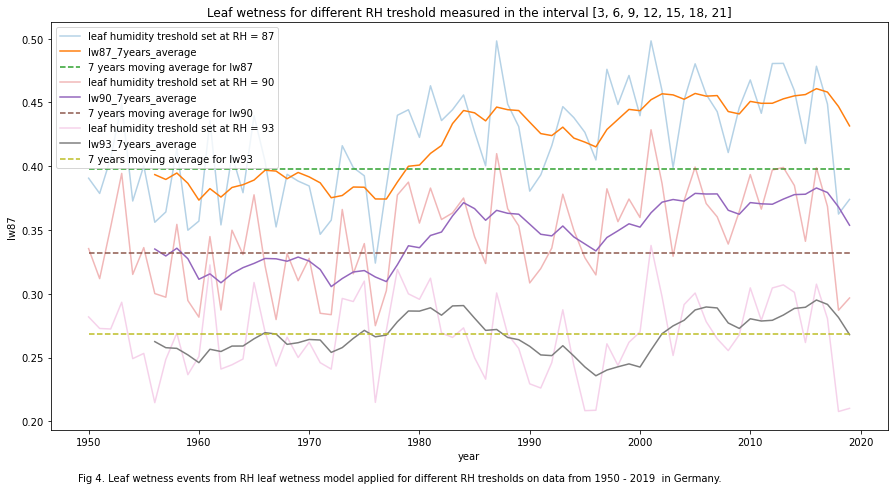

In [14]:
plot_lw_RHt(df_moisture,
            thresholds=[87,90,93],
            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
            hist_start=1950,hist_end=1985, 
            hours=[3,6,9,12,15,18,21],
            moving_average=7,
            
            )

# Leaf wetness model 2

"The difference between T and dew point temperature (Td) is the dew point depression (DPD) which has also been suggested as a LWD estimator by Huber and Gillespie (1992) and Gillespie et al. (1993), based on the same observations done by Monteith (1957) in relation to RH. Duration of wetness is estimated as the length of time that DPD remains between two specific limits. The wetness criteria for this study were DPD ≤ 1.8 °C for wetness onset and DPD ≥ 2.2 °C for wetness dry-off (Rao et al., 1998)."

In [15]:
df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing unknown values with np.nan so they will not be counted in the statistic
df_dew_point.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


<AxesSubplot:xlabel='year', ylabel='TD'>

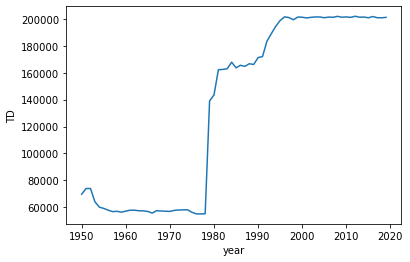

In [16]:
#Checking data integrity and quality
df_dpd = df_dew_point.copy()
measures = df_dpd.groupby("year").count()
sns.lineplot(x=measures.index,y=measures.TD)

Again, I can not apply the model and look for consecutive times with leaf wetness because until 1990 the dew point is measured every 3 hours. But we can work with %.

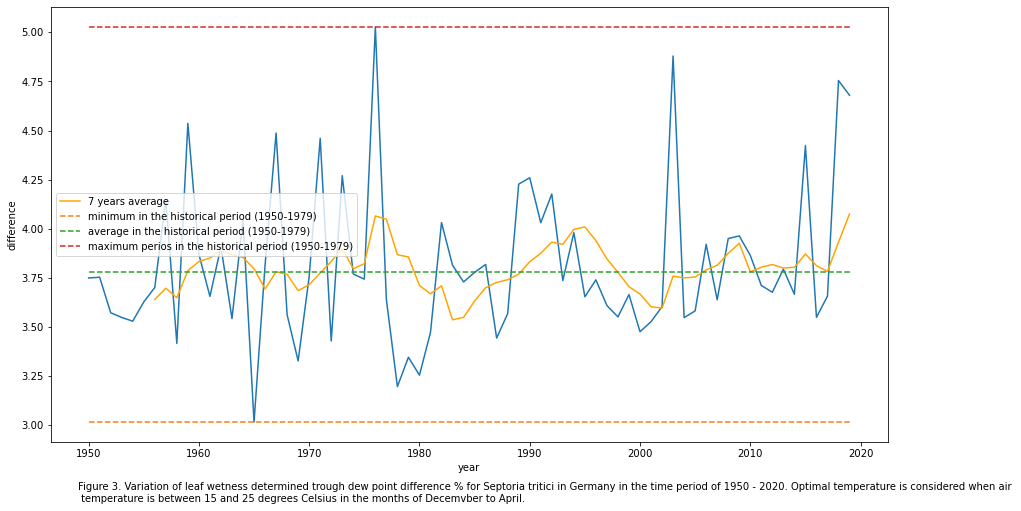

In [17]:
plot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)

### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

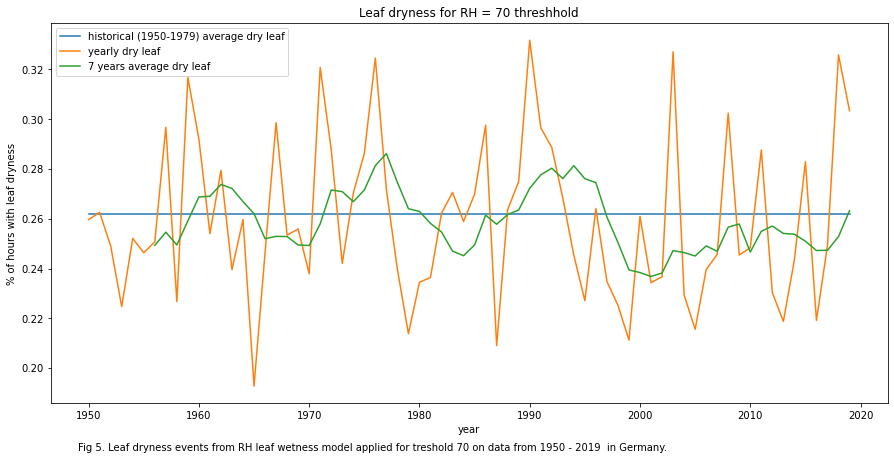

In [18]:
df_dryness = df_moisture.copy()
plot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)

#### Fusarium graminearum

In [19]:
#df_merged = pd.merge(df_airtemp,df_moisture,  how='left', left_on=['STATIONS_ID','MESS_DATUM'])#, right_on = ['RF_STD'])
#df_merged= df_airtemp.merge(df_moisture, on=['STATIONS_ID','MESS_DATUM','year','month','hour'])

 T = [20-25]
 Months = [6,7,8]
 Source: https://journals.asm.org/doi/full/10.1128/AEM.02436-15
 It says: BBCH stage 61 to 75 for corn, I need source

In [20]:
df_moisture= download_dwd_data("moisture","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

All given ids accounted for


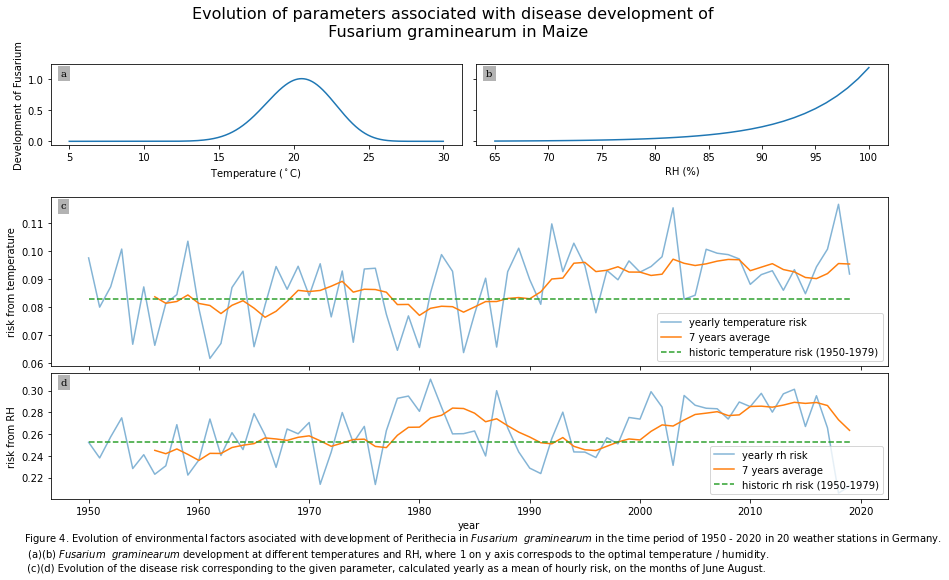

In [21]:
plot_risk_fusarium(df_airtemp, df_moisture,
temp_min=15,temp_max=25,
hist_start=1950,hist_end=1979,
#start_dd_mm="01.09", end_dd_mm="01.05",
start_dd_mm=corn_harvest_date, end_dd_mm=wheat_harvest_date, 
moving_average=7 
)

# Making a linear regression

In [22]:
from scipy.stats import linregress
from scipy import stats


def liniar_model_temperature(df_airtemp:pd.DataFrame,start_dd_mm:str,end_dd_mm:str,func, year_minus:int=0):
    results = pd.DataFrame(columns=['station id', 'r_value',"gradient","intercept", "p_value", "conclusion"])
    df = df_airtemp.copy()
    for station in df.STATIONS_ID.unique():
        save_station = station
        df = df_airtemp.copy()
        df = df[df["STATIONS_ID"] == station]
        df = select_time_range(df,start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm)
        df["useful_t"] = df.TT_TU.apply(func)

        df= df.groupby(["year"]).mean().reset_index()

        x= [ i - year_minus for i in df.year ]
        y= df.useful_t
        gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        if p_value < 0.05 and gradient >0:
            verdict = "significant"
        elif p_value < 0.05 and gradient <0:
            verdict = "significant but decreasing risk"
        else:# p_value > 0.05:
            verdict = "non-significant"
        
        results_new_row = pd.DataFrame({'station id':[save_station], 'r_value':[r_value],"gradient":[gradient],"intercept":[intercept], "p_value":[p_value], "conclusion":[verdict]})
        results = pd.concat([results, results_new_row], ignore_index=True)
    return results
liniar_model_temperature(df_airtemp,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium,year_minus=0).to_csv("/Users/serbanradulescu/Documents/master_thesis/results/lm_temperature.csv")
#print(simple_common_stations(df_moisture.STATIONS_ID.unique(),df_airtemp.STATIONS_ID.unique()))

In [23]:
def liniar_model_moisture(df_moisture:pd.DataFrame,start_dd_mm:str,end_dd_mm:str,func, year_minus:int=0):
    results = pd.DataFrame(columns=['station id', 'r_value',"gradient","intercept", "p_value", "conclusion"])
    df = df_moisture.copy()
    for station in df.STATIONS_ID.unique():
        save_station = station
        df = df_moisture.copy()
        df = df[df["STATIONS_ID"] == station]
        df = df[df["hour"].isin([3,6,9,12,15,18,21])]
        df = select_time_range(df,start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm)
        df["useful_humidity"] = df.RF_STD.apply(func)

        df= df.groupby(["year"]).mean().reset_index()

        x= [ i - year_minus for i in df.year ]
        y= df.useful_humidity
        gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        if p_value < 0.05 and gradient >0:
            verdict = "significant"
        elif p_value < 0.05 and gradient <0:
            verdict = "significant but decreasing risk"
        elif p_value > 0.05:
            verdict = "non-significant"
        
        results_new_row = pd.DataFrame({'station id':[save_station], 'r_value':[r_value],"gradient":[gradient],"intercept":[intercept], "p_value":[p_value], "conclusion":[verdict]})
        results = pd.concat([results, results_new_row], ignore_index=True)
    return results
liniar_model_moisture(df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium_rh,year_minus=0).to_csv("/Users/serbanradulescu/Documents/master_thesis/results/lm_moisture.csv")

# Now taking also the coodinates into consideration 

-22.4 15.6


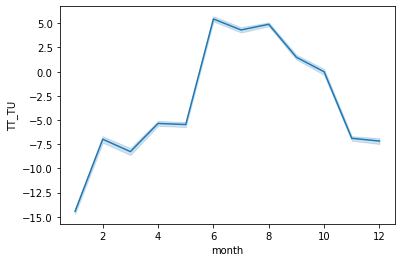

In [24]:
df = df_airtemp.copy()
broken_id = df[df["STATIONS_ID"] == "05792"]
broken_id = broken_id[broken_id["year"] == 2019]
sns.lineplot(x=broken_id["month"], y = broken_id["TT_TU"])
print(min(broken_id["TT_TU"]),max(broken_id["TT_TU"]))

In [25]:
#stations_coordinates = coordinates_stations(["05792"],"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")
#print(stations_coordinates)
repl = dict(zip(stations_coordinates['id'], stations_coordinates['lat']))
#print(repl[""])
df = df_airtemp.copy()
df = df[df["month"].isin([5,6,7])]
df["risk_t"] = df.TT_TU.apply(equation_fusarium)

df= df.groupby(["year","STATIONS_ID"]).mean().reset_index()
#df= df.groupby(["year"]).mean().reset_index()
#df.replace({"STATIONS_ID":repl},inplace = True)
#df.rename(columns = {'STATIONS_ID':'lat'},inplace = True)

x= df[["year","STATIONS_ID"]]
y= df.useful_t


NameError: name 'stations_coordinates' is not defined

['05792']


<AxesSubplot:xlabel='year', ylabel='TT_TU'>

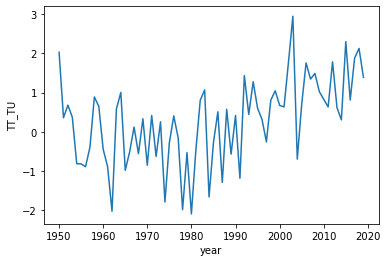

In [ ]:
print(df[df["risk_t"]<= 0.02].STATIONS_ID.unique())


In [ ]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print(regr.score(x,y))

Intercept: 
 -1.946548386582474
Coefficients: 
 [0.00093145 0.0059162 ]
0.09245808681530876


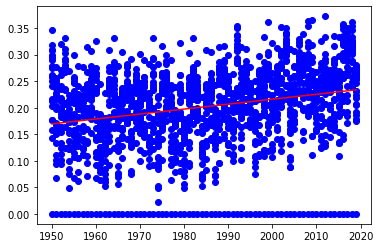

0.2526578456893694
      year     lat    MESS_DATUM  QN_9     TT_TU      RF_TU  month        day  \
21    1950  47.421  1.950062e+09   5.0  2.031476  83.302083    6.0  15.836957   
44    1951  47.421  1.951062e+09   5.0  0.356703  84.320652    6.0  15.836957   
67    1952  47.421  1.952062e+09   5.0  0.678895  80.091938    6.0  15.836957   
90    1953  47.421  1.953062e+09   5.0  0.372373  85.873188    6.0  15.836957   
113   1954  47.421  1.954062e+09   5.0 -0.818478  87.501812    6.0  15.836957   
...    ...     ...           ...   ...       ...        ...    ...        ...   
1577  2015  47.421  2.015062e+09   3.0  2.302129  85.705163    6.0  15.836957   
1601  2016  47.421  2.016062e+09   3.0  0.808832  89.543478    6.0  15.836957   
1625  2017  47.421  2.017062e+09   3.0  1.882699  86.373921    6.0  15.836957   
1649  2018  47.421  2.018062e+09   3.0  2.129755  88.006434    6.0  15.836957   
1673  2019  47.421  2.019062e+09   3.0  1.388043  82.620924    6.0  15.836957   

      ho

In [ ]:
from scipy import stats
x = df.year
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)


mn=np.min(x)
mx=np.max(x)

x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
plt.show()

print(r_value)



BBCH explorer